In [1]:
from typing import List, Tuple, Optional

import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from karateclub.graph_embedding import Graph2Vec
from tqdm import tqdm

from master_thesis.classification_models import LDPModel, VectorModel
from master_thesis.tools.plots import plot_sample_networks

SEED = 42
K_FOLDS = 10
NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeBias/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksGC/networks"

# Load dataset

In [2]:
# Load network files
filenames = [f for f in os.listdir(NETWORKS_DIR_PATH) if f.endswith(".npy")]
print(f"Found {len(filenames)} networks")

Found 1000 networks


In [3]:
def load_networks(networks_dir: str, channel: Optional[int] = None) -> Tuple[List[nx.DiGraph], List[int]]:

    # Get filenames
    filenames = [f for f in os.listdir(networks_dir) if f.endswith(".npy")]

    # Create paths
    paths = [os.path.join(networks_dir, f) for f in filenames]

    # Load networks to numpy arrays
    networks = [np.load(p) for p in paths]
    networks = [net[channel] if channel is not None else net for net in networks]

    # Convert to networkx graphs
    nx_networks = [nx.from_numpy_array(net, create_using=nx.DiGraph) for net in networks]

    # Extract labels
    labels = [x.split("-")[1][:3] == "PAT" for x in filenames]

    return nx_networks, labels

In [9]:
# Load networks
X, y = load_networks(NETWORKS_DIR_PATH)

### Plot sample class members

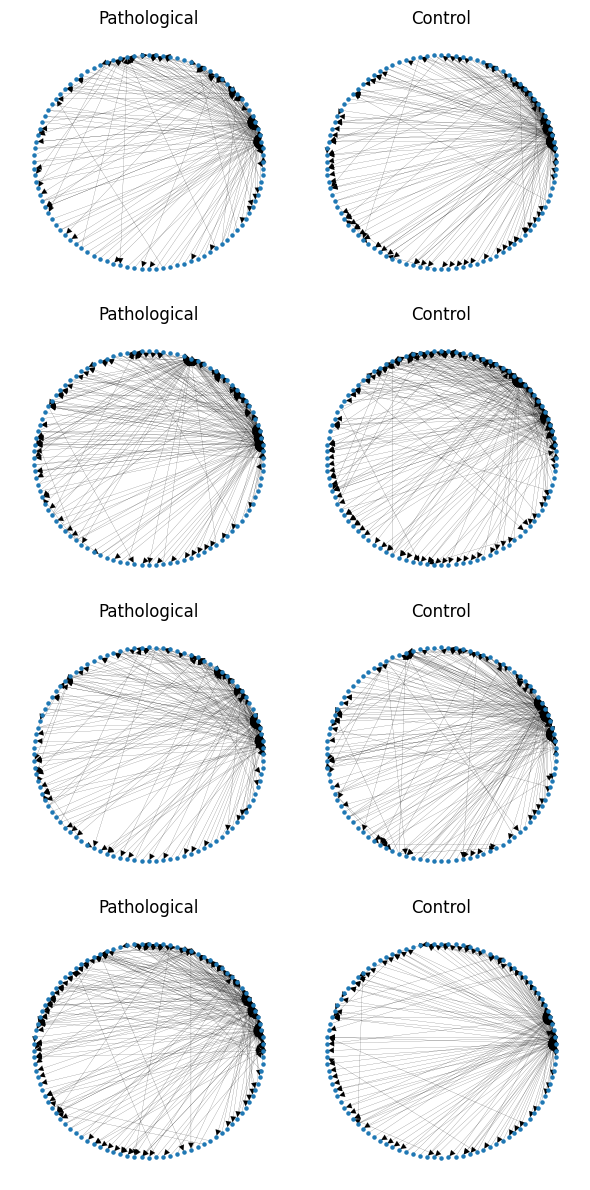

In [5]:
# Plot sample networks
plot_sample_networks(X, y)

## Preprocess networks
### TODO

In [10]:
graph2vec = Graph2Vec(dimensions=32, wl_iterations=2, epochs=200, seed=SEED, workers=1)
graph2vec.fit(X)
X = graph2vec.get_embedding()

# Pipe through the LDP model

## Leave-one-out cross-validation

Cross-validation: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

Train accuracy: 0.92
Train recall: 0.92
Train precision: 0.93
Train f1: 0.92
Train AUC: 0.92


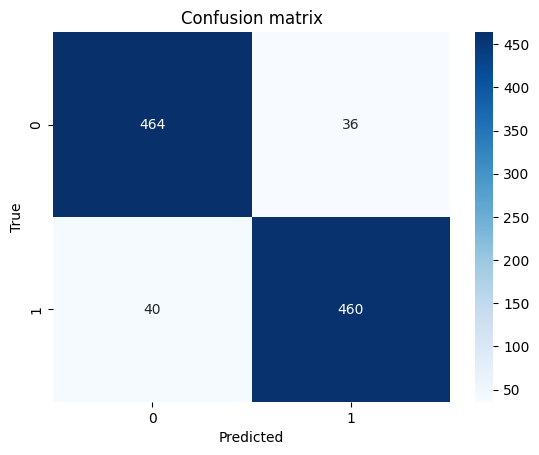

<Figure size 640x480 with 0 Axes>

In [14]:
# Define accumulator lists
y_gold_acc, y_hat_acc = [], []

# Define k-fold cross-validation
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in tqdm(enumerate(kfold.split(X)), total=K_FOLDS, desc="Cross-validation"):

    # Split data
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train model
    model = VectorModel(classifier_type="mlp", classifier_kwargs={
        "hidden_layer_sizes": (64, 16),
        "max_iter": 1000
    })
    model.fit(X_train, y_train)

    # Predict
    y_hat = model.predict(X_test)
    y_gold_acc.append(y_test)
    y_hat_acc.append(y_hat)

# Concatenate lists
y_gold = np.concatenate(y_gold_acc)
y_hat = np.concatenate(y_hat_acc)

# Evaluate classification
model.evaluate(y_gold, y_hat)